In [1]:
import scanpy as sc

from scprint import scPrint
from scprint.tasks import Embedder

from scdataloader import Preprocessor

import numpy as np

from scib_metrics.benchmark import Benchmarker

from collections import Counter

import bionty as bt
from scdataloader.utils import get_descendants
from sklearn.metrics import f1_score

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')


💡 connected lamindb: jkobject/scprint


2024-05-20 20:03:56,834:INFO - Downloading data from `https://omnipathdb.org/queries/enzsub?format=json`
2024-05-20 20:03:56,944:INFO - Downloading data from `https://omnipathdb.org/queries/interactions?format=json`
2024-05-20 20:03:57,033:INFO - Downloading data from `https://omnipathdb.org/queries/complexes?format=json`
2024-05-20 20:03:57,128:INFO - Downloading data from `https://omnipathdb.org/queries/annotations?format=json`
2024-05-20 20:03:57,217:INFO - Downloading data from `https://omnipathdb.org/queries/intercell?format=json`
2024-05-20 20:03:57,430:INFO - Downloading data from `https://omnipathdb.org/about?format=text`
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core

## preparing the model


In [2]:
model = scPrint.load_from_checkpoint(
    '../../data/temp/wli32e2j/last.ckpt', precpt_gene_emb=None)

RuntimeError caught: scPrint is not attached to a `Trainer`.



## Loading the data


In [4]:
# only dataset dropped
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/gNNpgpo6gATjuxTE7CCp.h5ad')

# one that it trained on: z7ZZxORUQFshySbuvNW7. 2PN6LTuSmJI2TSGl77TY.h5ad
# untrained on: BljRloq1xjcxRNDpejzI
# testdatasets=['/R4ZHoQegxXdSFNFY5LGe.h5ad', '/SHV11AEetZOms4Wh7Ehb.h5ad', '/V6DPJx8rP3wWRQ43LMHb.h5ad', '/Gz5G2ETTEuuRDgwm7brA.h5ad', '/YyBdEsN89p2aF4xJY1CW.h5ad', '/SO5yBTUDBgkAmz0QbG8K.h5ad', '/r4iCehg3Tw5IbCLiCIbl.h5ad', '/SqvXr3i3PGXM8toXzUf9.h5ad', '/REIyQZE6OMZm1S3W2Dxi.h5ad', '/rYZ7gs0E0cqPOLONC8ia.h5ad', '/FcwMDDbAQPNYIjcYNxoc.h5ad', '/fvU5BAMJrm7vrgDmZM0z.h5ad', '/gNNpgpo6gATjuxTE7CCp.h5ad'],

In [6]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)

  0%|          | 0.00/301M [00:00<?, ?B/s]

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/

In [3]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/__categories/dataset' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/dataset' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarnin

In [4]:
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
preprocessor = Preprocessor(subset_hvg=3000, use_layer='counts', is_symbol=True,
                            force_preprocess=True, skip_validate=True, do_postp=False)
adata = preprocessor(adata.copy())
adata

X was not raw counts, using 'counts' layer
Dropping layers:  KeysView(Layers with keys: counts)
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 32472 renamining
filtered out 221 cells, 32251 renamining
Removed 0 genes.
startin QC
Seeing 10331 outliers (32.03% of total dataset):
done


View of AnnData object with n_obs × n_vars = 32251 × 70116
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'description', 'synonyms', 'organism_id', 'public_source_id', 'created_by_id', 'mt', 'ribo', 'hb', 'organism', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'unseen_genes'

In [7]:
Counter(adata.obs.tech)  # assay

AttributeError: 'DataFrameView' object has no attribute 'assay'

In [8]:
Counter(adata.obs.cell_type)  # cell_type

Counter({'Macrophage': 7433,
         'Type 2': 4246,
         'Ciliated': 3145,
         'Basal 2': 3072,
         'Secretory': 2433,
         'Basal 1': 1972,
         'T/NK cell': 1771,
         'Neutrophil_CD14_high': 1626,
         'Dendritic cell': 1367,
         'B cell': 1331,
         'Endothelium': 978,
         'Mast cell': 877,
         'Fibroblast': 730,
         'Neutrophils_IL1R2': 472,
         'Type 1': 418,
         'Lymphatic': 334,
         'Ionocytes': 46})

# good dataset


In [5]:
embed = Embedder(model, how="random expr", max_len=3200, add_zero_genes=0,
                 num_workers=32, pred_embedding=["cell_type_ontology_term_id"])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## test dataset


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

adding on disk
AnnData object with n_obs × n_vars = 32251 × 512
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in panda

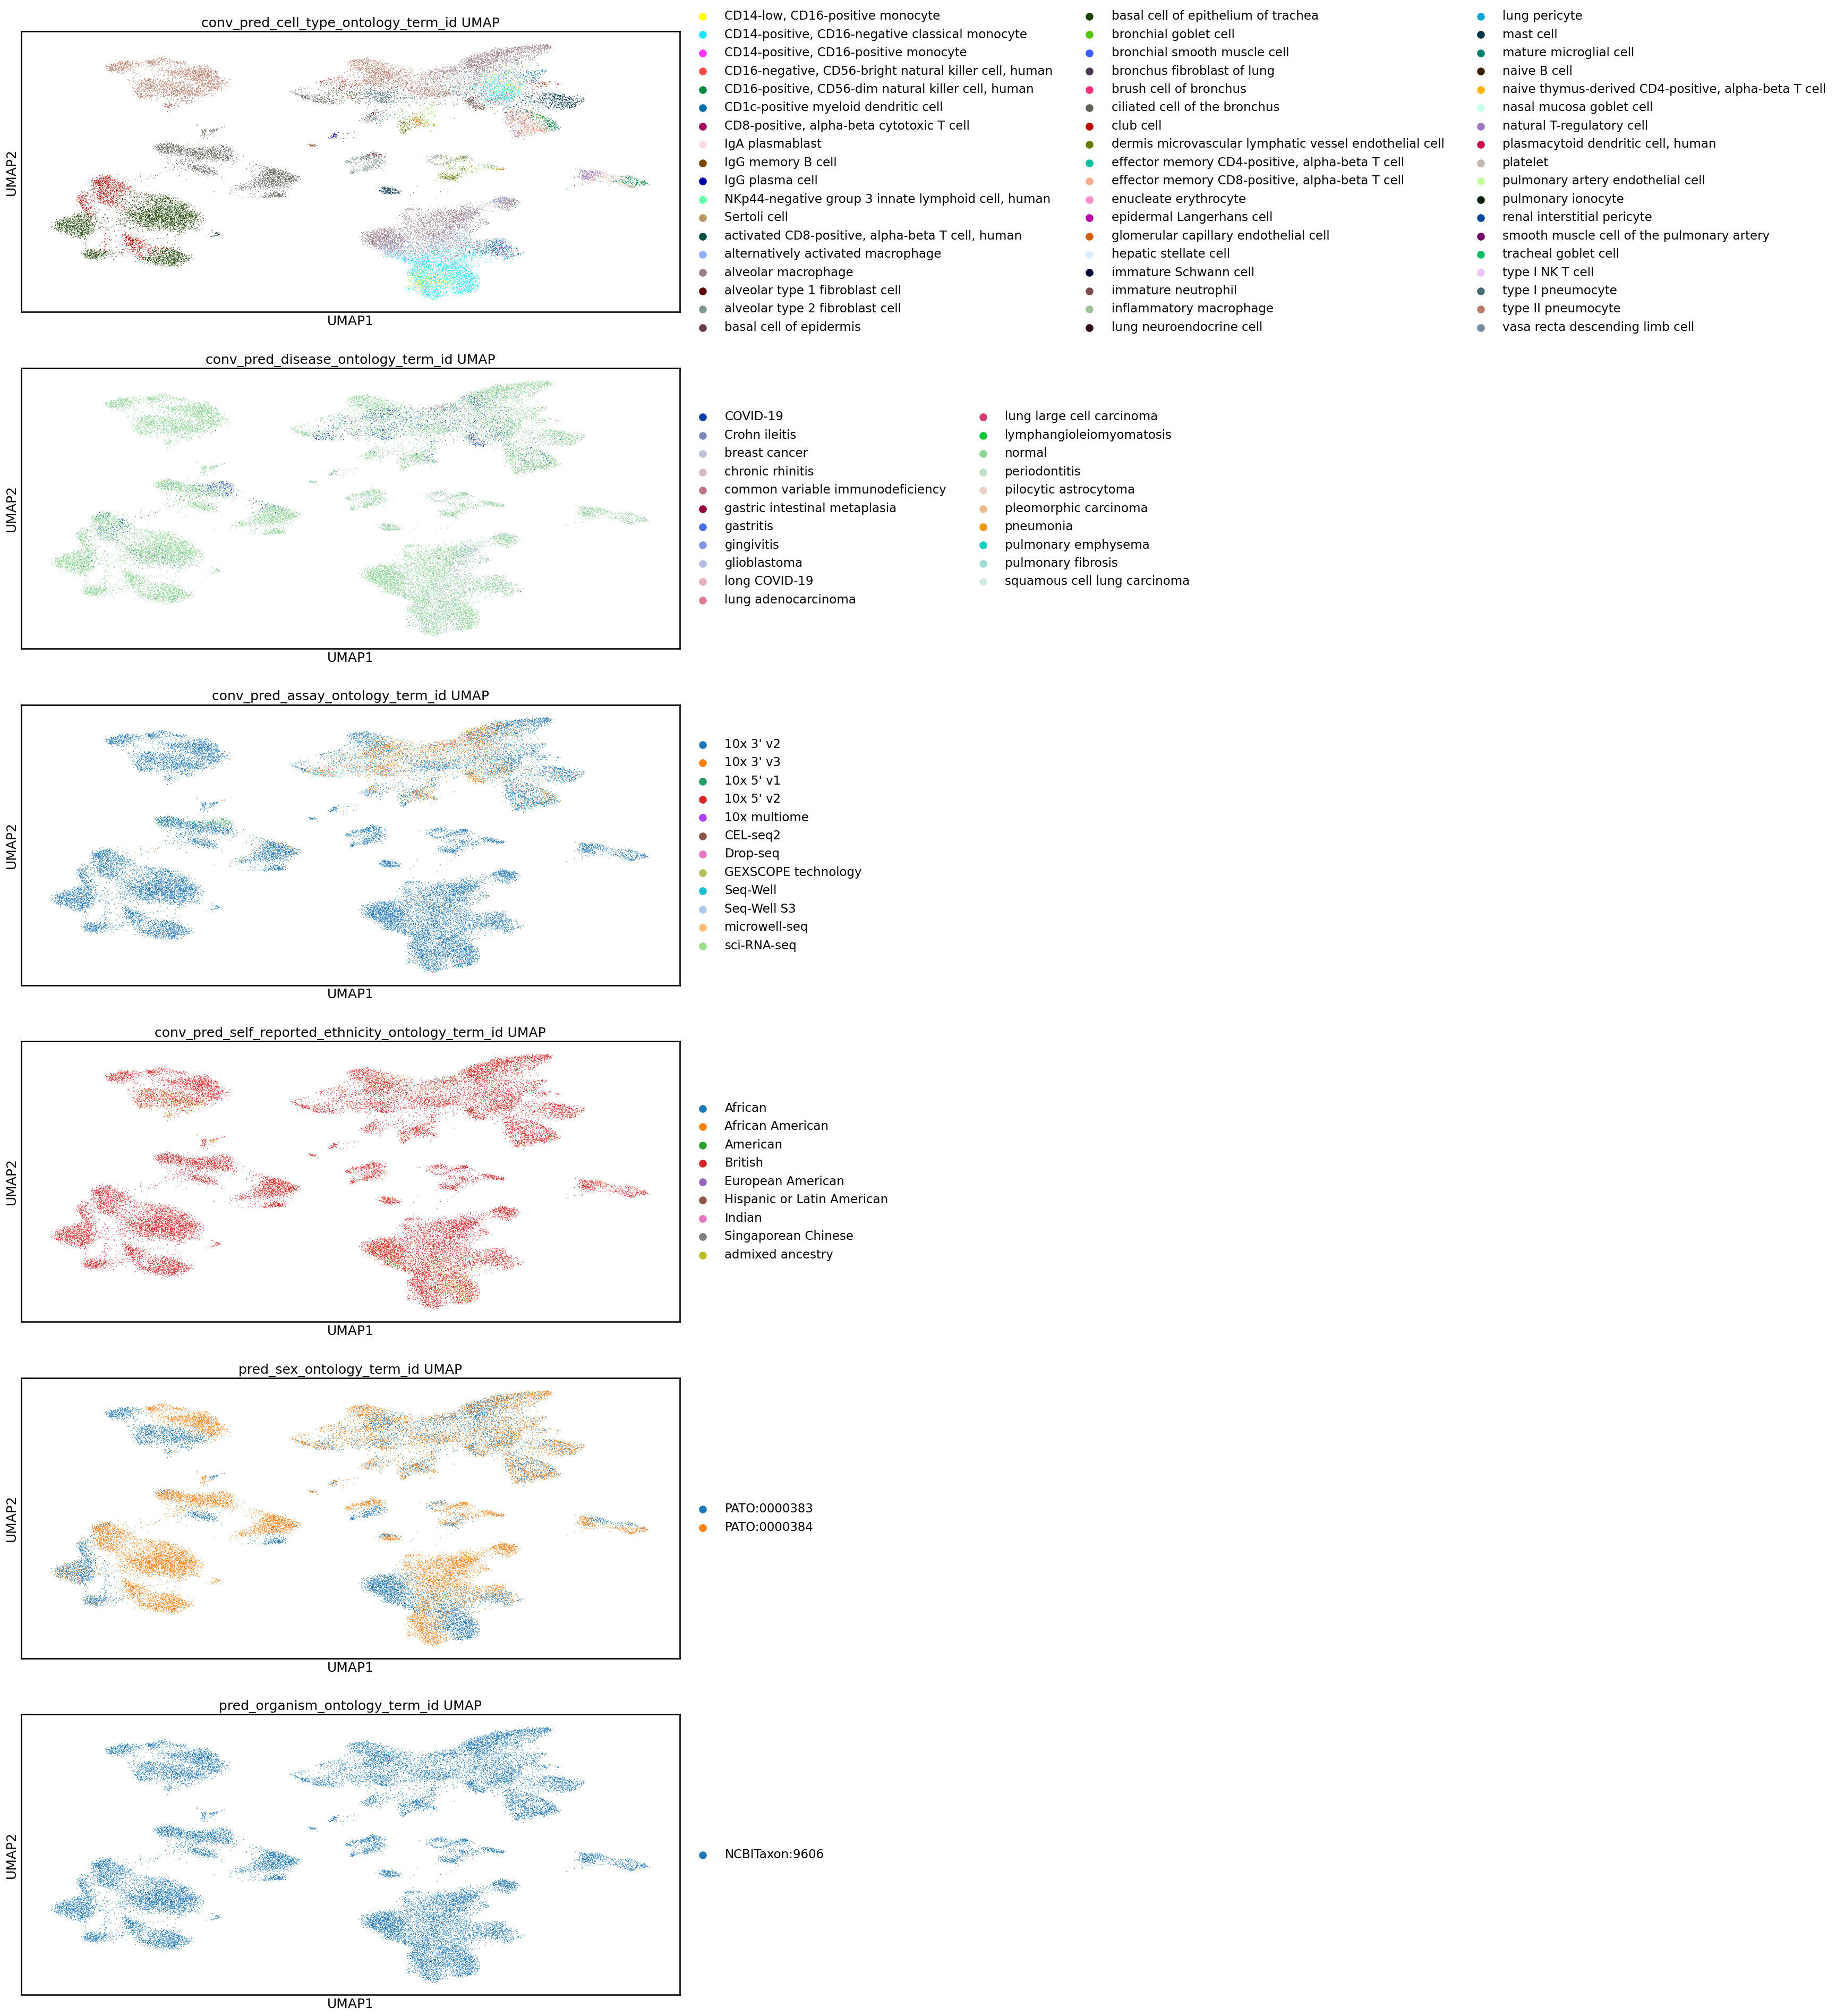

couldn't log to tensorboard
couldn't log to wandb
     organism_ontology_term_id
     accuracy: 1.0
 


In [6]:
n_adata, metrics = embed(
    adata.copy()[:], cache=False, output_expression="none")

In [7]:
sc.pp.pca(n_adata)

In [9]:
bm = Benchmarker(
    n_adata,
    batch_key="batch",  # batch, tech
    label_key="cell_type",  # celltype
    embedding_obsm_keys=["X_pca", "scprint"],
    n_jobs=20,
)
bm.benchmark()

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]2024-05-20 20:31:57,611:INFO - isolated labels: no more than 4 batches per label

Metrics:  60%|██████    | 6/10 [02:08<00:50, 12.59s/it, Batch correction: kbet_per_label]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instea

In [10]:
a

NameError: name 'a' is not defined

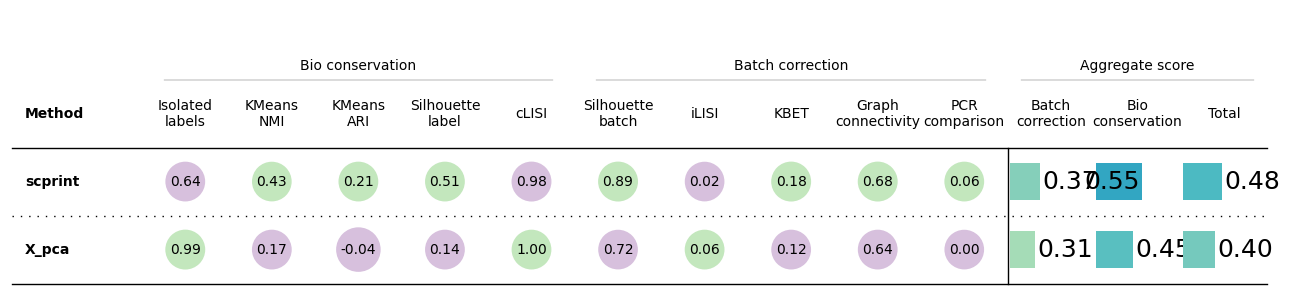

In [12]:
# panc
bm.plot_results_table(min_max_scale=False)

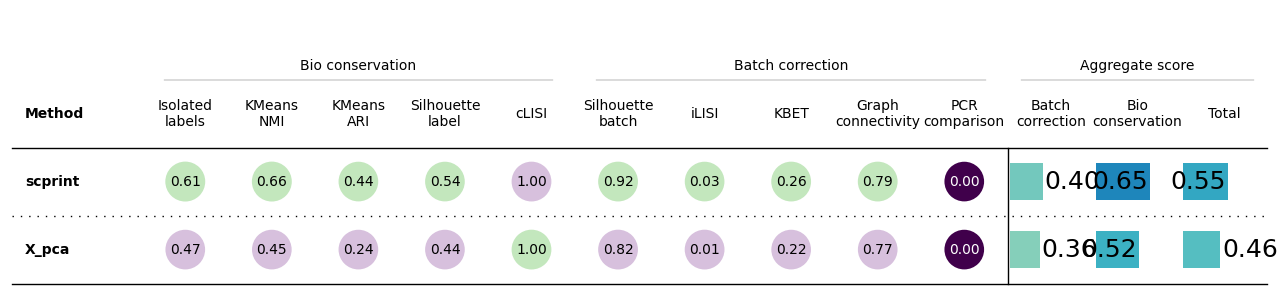

In [11]:
# lung
bm.plot_results_table(min_max_scale=False)

In [19]:
n_adata.obs.celltype.value_counts()

celltype
alpha                 5493
beta                  4169
ductal                2142
acinar                1669
delta                 1055
gamma                  699
activated_stellate     464
endothelial            313
quiescent_stellate     193
macrophage              79
mast                    42
epsilon                 32
schwann                 25
t_cell                   7
Name: count, dtype: int64

In [20]:
n_adata.obs.loc[n_adata.obs.celltype ==
                "activated_stellate"].conv_pred_cell_type_ontology_term_id.value_counts()

conv_pred_cell_type_ontology_term_id
bronchus fibroblast of lung                               421
lung pericyte                                               7
alveolar type 2 fibroblast cell                             6
dermis microvascular lymphatic vessel endothelial cell      5
malignant cell                                              4
                                                         ... 
fibroblast of breast                                        0
fast muscle cell                                            0
extravillous trophoblast                                    0
erythroid progenitor cell, mammalian                        0
ventricular cardiac muscle cell                             0
Name: count, Length: 91, dtype: int64

In [15]:
obj = bt.CellType.public(organism="all")
{i: obj.search(i, field="name").ontology_id.iloc[0] for i in set(
    n_adata.obs['cell_type'])}

{'Type 2': 'CL:0000784',
 'Macrophage': 'CL:0000235',
 'Mast cell': 'CL:0000097',
 'Ciliated': 'CL:0005012',
 'Ionocytes': 'CL:0005006',
 'Basal 1': 'CL:0000646',
 'Neutrophil_CD14_high': 'CL:0000775',
 'B cell': 'CL:0000236',
 'Type 1': 'CL:0000990',
 'Endothelium': 'CL:2000009',
 'Neutrophils_IL1R2': 'CL:0000775',
 'Lymphatic': 'CL:0009107',
 'Fibroblast': 'CL:0000057',
 'T/NK cell': 'CL:0000623',
 'Secretory': 'CL:0011003',
 'Basal 2': 'CL:0000646',
 'Dendritic cell': 'CL:0000451'}

In [26]:
fine = {"gamma": "CL:0002275",
        "beta": "CL:0000169",  # "CL:0008024"
        "epsilon": "CL:0005019",  # "CL:0008024"
        "acinar": "CL:0000622",
        'delta': 'CL:0000173',  # "CL:0008024"
        'schwann': 'CL:0002573',  # "CL:0000125"
        'activated_stellate': 'CL:0000057',
        'alpha': 'CL:0000171',  # "CL:0008024"
        'mast': 'CL:0000097',
        'Mast cell': 'CL:0000097',
        'quiescent_stellate': 'CL:0000057',
        't_cell': 'CL:0000084',
        'endothelial': 'CL:0000115',
        'Endothelium': 'CL:0000115',
        'ductal': 'CL:0002079',  # CL:0000068
        'macrophage': 'CL:0000235',
        'Macrophage': 'CL:0000235',
        'B cell': 'CL:0000236',
        'Type 2': 'CL:0002063',
        'Type 1': 'CL:0002062',
        'Ciliated': 'CL:4030034',  # respiratory ciliated
        'Dendritic cell': 'CL:0000451',  # leukocyte
        'Secretory': 'CL:0000151',
        'Ionocytes': 'CL:0005006',
        'Basal 1': 'CL:0000646',  # epithelial
        'Basal 2': 'CL:0000646',
        'Neutrophil_CD14_high': 'CL:0000775',
        'Neutrophils_IL1R2': 'CL:0000775',
        'Lymphatic': 'CL:0002138',
        'Fibroblast': 'CL:0000057',
        'T/NK cell': 'CL:0000814',

        'inDrop1': 'EFO:0008780',
        'inDrop3': 'EFO:0008780',
        'inDrop4': 'EFO:0008780',
        'inDrop2': 'EFO:0008780',

        'fluidigmc1': 'EFO:0010058',  # fluidigm c1
        'smarter': 'EFO:0010058',  # fluidigm c1

        'celseq2': 'EFO:0010010',

        'smartseq2': 'EFO:0008931',

        'celseq': 'EFO:0008679',
        }
coarse = {
    "beta": "CL:0008024",  # endocrine
    "epsilon": "CL:0008024",
    'delta': "CL:0008024",
    'alpha': "CL:0008024",
    "gamma": "CL:0008024",

    "acinar": "CL:0000150",  # epithelial (gland)
    'ductal': "CL:0000068",  # epithelial (duct)

    'schwann': "CL:0000125",  # glial

    'endothelial': 'CL:0000115',
    'Endothelium': 'CL:0000115',
    'Lymphatic': 'CL:0000115',

    'macrophage': 'CL:0000235',  # myeloid leukocyte (not)
    'Macrophage': 'CL:0000235',  # myeloid leukocyte
    'mast': 'CL:0000097',  # myeloid leukocyte (not)
    'Mast cell': 'CL:0000097',  # myeloid leukocyte
    'Neutrophil_CD14_high': 'CL:0000775',  # myeloid leukocyte
    'Neutrophils_IL1R2': 'CL:0000775',  # myeloid leukocyte

    't_cell': 'CL:0000084',  # leukocyte, lymphocyte (not)
    'T/NK cell': 'CL:0000084',  # leukocyte, lymphocyte (not)
    'B cell': 'CL:0000236',  # leukocyte, lymphocyte (not)
    'Dendritic cell': 'CL:0000451',  # leukocyte, lymphocyte

    'activated_stellate': 'CL:0000057',  # fibroblast (not)
    'quiescent_stellate': 'CL:0000057',  # fibroblast (not)
    'Fibroblast': 'CL:0000057',

    'Type 2': 'CL:0000066',  # epithelial
    'Type 1': 'CL:0000066',
    'Ionocytes': 'CL:0000066',  # epithelial
    'Basal 1': 'CL:0000066',  # epithelial
    'Basal 2': 'CL:0000066',

    'Ciliated': 'CL:0000064',  # ciliated

    'Secretory': 'CL:0000151',

    'inDrop1': 'EFO:0008780',
    'inDrop3': 'EFO:0008780',
    'inDrop4': 'EFO:0008780',
    'inDrop2': 'EFO:0008780',

    'fluidigmc1': 'EFO:0010058',  # fluidigm c1
    'smarter': 'EFO:0010058',  # fluidigm c1

    'celseq2': 'EFO:0010010',

    'smartseq2': 'EFO:0008931',

    'celseq': 'EFO:0008679',
}

In [21]:
n_adata.obs['cell_type_ontology_term_id'] = n_adata.obs['celltype'].replace(
    fine)  # fine, coarse
# n_adata.obs['cell_type_ontology_term_id'] = n_adata.obs['celltype'].replace(coarse)

/tmp/ipykernel_1491324/2436405469.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  n_adata.obs['cell_type_ontology_term_id'] = n_adata.obs['celltype'].replace(


In [22]:
metrics = {}
for label in embed.model.classes:
    res = []
    if label not in n_adata.obs.columns:
        continue
    labels_topred = embed.model.label_decoders[label].values()
    if label in embed.model.labels_hierarchy:
        parentdf = (
            bt.CellType.filter()
            .df(include=["parents__ontology_id"])
            .set_index("ontology_id")[['parents__ontology_id']]
        )
        parentdf.parents__ontology_id = parentdf.parents__ontology_id.astype(
            str)
        class_groupings = {
            k: get_descendants(k, parentdf)
            for k in set(n_adata.obs[label].unique())
        }
    for pred, true in n_adata.obs[["pred_" + label, label]].values:
        if pred == true:
            res.append(true)
            continue
        if label in embed.model.labels_hierarchy:
            if true in class_groupings:
                res.append(true if pred in class_groupings[true] else "")
                continue
            elif true not in labels_topred:
                raise ValueError(f"true label {true} not in available classes")
        elif true not in labels_topred:
            raise ValueError(f"true label {true} not in available classes")
        res.append("")
    metrics[label] = {}
    metrics[label]['accuracy'] = np.mean(
        np.array(res) == n_adata.obs[label].values)
    metric_type = ["macro", "micro", "weighted"]
    for x in metric_type:
        metrics[label][x] = f1_score(
            np.array(res),
            n_adata.obs[label].values,
            average=x
        )
metrics

{'cell_type_ontology_term_id': {'accuracy': 0.8857892809180808,
  'macro': 0.7118171815254941,
  'micro': 0.8857892809180808,
  'weighted': 0.839695462389555},
 'organism_ontology_term_id': {'accuracy': 1.0,
  'macro': 1.0,
  'micro': 1.0,
  'weighted': 1.0}}

{'cell_type_ontology_term_id': {'accuracy': 0.4146624343791967,
  'macro': 0.5532796551305788,
  'micro': 0.4146624343791967,
  'weighted': 0.2892868050838839},
 'organism_ontology_term_id': {'accuracy': 1.0,
  'macro': 1.0,
  'micro': 1.0,
  'weighted': 1.0}}